## Примеры источников разреженных признаков

* Результат one-hot-encoding для большого количества категориальных признаков
* Тексты и любые последовательности, которые можно интерпретировать как "bag of words"

## Разреженные матрицы

Существует много типов разреженных матриц, каждый из которых предоставляет разные гарантии на операции.

* ```scipy.sparse.bsr_matrix```
* ```scipy.sparse.coo_matrix```
* ```scipy.sparse.csc_matrix```
* ```scipy.sparse.csr_matrix```
* ```scipy.sparse.dia_matrix```
* ```scipy.sparse.dok_matrix```
* ```scipy.sparse.lil_matrix```

Подробнее про [устройство разреженых матрицы](http://www.netlib.org/utk/people/JackDongarra/etemplates/node372.html)


## scipy.sparse.coo_matrix

* Используется как хранилище данных
* Поддерживает быструю конвертацию в любой формат
* Не поддерживает индексацию
* Поддерживает ограниченый набор арифметических операций


## scipy.sparse.csr_matrix

* Хранит данные построчно
* Быстрое получение значений отдельных строк


## scipy.sparse.csc_matrix

* Хранит данные поколоночно
* Быстрое получение значений отдельных колонок


## scipy.sparse.lil_matrix

* Отлично подходит для создания разреженных матриц поэлементно
* Для последующих матричных операций лучше сконвертировать в ```csr_matrix``` или ```csc_matrix```


## Работа с разреженными данными

Библиотека ```scipy.sparse``` содержит методы, позволяющие работать с разреженными матрицами.

Например, специальные ```hstack``` и ```vstack``` для конкатенации.

Подробнее про операции с разрежеными матрицами на сайте [scipy](https://docs.scipy.org/doc/scipy/reference/sparse.html).


### Что можно использовать?

Подходят почти все модели
* LogisticRegression
* LinearSVC
* MultinomialNB
* RandomForestClassifier
* KNeighborsClassifier

Не подходят
* GradientBoostingClassifier

In [1]:
import pandas as pd
import numpy as np

import scipy.sparse
import sklearn.feature_extraction

import matplotlib.pylab as plt
%matplotlib inline

from tqdm import tqdm
import platform

pd.set_option("display.max_rows", 10)
pd.set_option('display.max_columns', 1100)

import os

In [2]:
print(platform.processor())
print('cpu\t\t: {}'.format(os.cpu_count()))

x86_64
cpu		: 4


План - создание **csr-matrix** порядковых дамми-признаков для дальнейшего анализа.

На входе - 3 **dense matrixes** - main_data, values_data, order_data.

In [3]:
from logParser import ParseLogsFromFolder

main_data, values_data, order_data = ParseLogsFromFolder('Logs/', 10, only_order=False)

  7%|▋         | 9/127 [00:06<01:20,  1.46it/s]


### В матрице Main table всего 3 столбца, которые глобально характеризуют хэдэр

In [4]:
main = pd.DataFrame(main_data)
del(main_data)
print('В матрице Main table всего 3 столбца, которые глобально характеризуют хэдэр')
main.head()

,User_Agent,id,ip
0,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,1485900038,95.181.252.91
1,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,1485900047,40.77.167.74
2,Mozilla/5.0 (Linux; Android 4.4.2; Zera S Buil...,1485900079,31.148.3.19
3,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:51.0) G...,1485900103,188.162.183.66
4,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,1485900105,37.144.52.103


In [5]:
main.shape

(289269, 3)

In [6]:
main.User_Agent.value_counts().reset_index()[:100]

,index,User_Agent
0,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,13375
1,Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http:...,11263
2,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,10950
3,Mozilla/5.0 (Windows NT 5.1; rv:7.0.1) Gecko/2...,9980
4,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,5346
...,...,...
95,Mozilla/5.0 (compatible; archive.org_bot +http...,315
96,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,314
97,Mozilla/5.0 (Linux; Android 5.1.1; SM-J120F Bu...,308
98,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,305


In [7]:
print('Хэдэры первых 100 юзер-агентов составляют: {:.2%}'.format(
    main.User_Agent.value_counts()[:100].sum() / main.shape[0]))

Хэдэры первых 100 юзер-агентов составляют: 62.87%


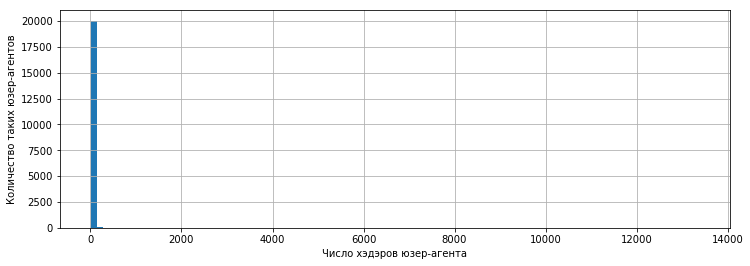

In [8]:
main.User_Agent.value_counts().hist(bins=100, figsize=(12,4))
plt.xlabel('Число хэдэров юзер-агента')
plt.ylabel('Количество таких юзер-агентов')

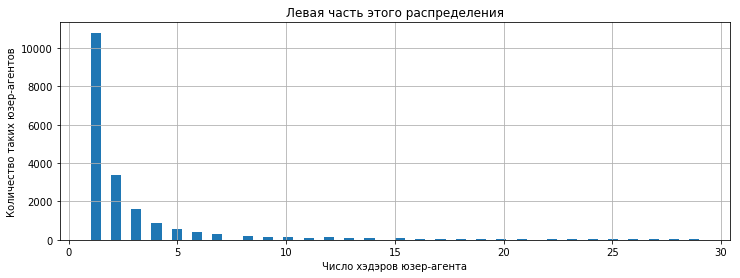

In [9]:
main.User_Agent.value_counts()[main.User_Agent.value_counts() < 30].hist(bins=60, figsize=(12,4))
plt.xlabel('Число хэдэров юзер-агента')
plt.ylabel('Количество таких юзер-агентов')
plt.title('Левая часть этого распределения')

Схороним индексы понравившихся нам хэдэров из топ-100

In [10]:
main_top_100 = main[main.User_Agent.isin(main.User_Agent.value_counts()[:100].index)]
del(main)
main_top_100.head()

,User_Agent,id,ip
0,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,1485900038,95.181.252.91
1,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,1485900047,40.77.167.74
3,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:51.0) G...,1485900103,188.162.183.66
8,Mozilla/5.0 (Windows NT 5.1; rv:7.0.1) Gecko/2...,1485900171,46.166.148.153
13,Mozilla/5.0 (Windows NT 5.1; rv:7.0.1) Gecko/2...,1485900228,204.85.191.30


## Order_data

В данной матрице содержится информация о взаимном расположении ключей.

Сразу переведем ее к типу **csr** с помощью DictVectorizer и проверим,что операция проведена корректно

In [11]:
order_data[:3]

[{'Accept': 3,
  'Accept-Encoding': 5,
  'Accept-Language': 6,
  'Referer': 4,
  'Upgrade-Insecure-Requests': 1,
  'User-Agent': 2},
 {'Accept': 2,
  'Accept-Encoding': 3,
  'From': 4,
  'Host': 5,
  'Pragma': 1,
  'User-Agent': 6},
 {'Accept': 1,
  'Accept-Encoding': 4,
  'Accept-Language': 5,
  'Cookie': 6,
  'Upgrade-Insecure-Requests': 2,
  'User-Agent': 3}]

In [12]:
orders_vectorizer = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
sparse_orders = orders_vectorizer.fit_transform(order_data).astype(np.int8)
del(order_data)
print('Sparse orders: \n{0}'.format(sparse_orders[:3]))
print(type(sparse_orders))

Sparse orders: 
  (0, 0)	3
  (0, 2)	5
  (0, 3)	6
  (0, 48)	4
  (0, 59)	1
  (0, 60)	2
  (1, 0)	2
  (1, 2)	3
  (1, 26)	4
  (1, 28)	5
  (1, 40)	1
  (1, 60)	6
  (2, 0)	1
  (2, 2)	4
  (2, 3)	5
  (2, 17)	6
  (2, 59)	2
  (2, 60)	3
<class 'scipy.sparse.csr.csr_matrix'>


In [13]:
orders_vectorizer.feature_names_[1:5], orders_vectorizer.feature_names_[56]

(['Accept-Charset', 'Accept-Encoding', 'Accept-Language', 'Authorization'],
 'Te')

### Еще немного полюбуемся на то что получилось

и осознаем как этим пользоваться.

Также замечу, что похожим образом можно получить векторизацию матрицы values_data. Вся разница - в том, что нам придется кодировать категориальные признаки. Тем не менее, пока не будем распыляться, чтобы хоть что-то до конца довести.

In [14]:
sparse_orders[0].data

array([3, 5, 6, 4, 1, 2], dtype=int8)

In [15]:
sparse_orders[0].indices

array([ 0,  2,  3, 48, 59, 60], dtype=int32)

In [16]:
np.array(orders_vectorizer.feature_names_)[sparse_orders[0].indices]

array(['Accept', 'Accept-Encoding', 'Accept-Language', 'Referer',
       'Upgrade-Insecure-Requests', 'User-Agent'], 
      dtype='<U29')

In [17]:
sparse_orders[0:6].indptr

array([ 0,  6, 12, 18, 25, 31, 35], dtype=int32)

In [18]:
print('Sparse orders: \n{0}'.format(sparse_orders[:6]))

Sparse orders: 
  (0, 0)	3
  (0, 2)	5
  (0, 3)	6
  (0, 48)	4
  (0, 59)	1
  (0, 60)	2
  (1, 0)	2
  (1, 2)	3
  (1, 26)	4
  (1, 28)	5
  (1, 40)	1
  (1, 60)	6
  (2, 0)	1
  (2, 2)	4
  (2, 3)	5
  (2, 17)	6
  (2, 59)	2
  (2, 60)	3
  (3, 0)	1
  (3, 2)	3
  (3, 3)	2
  (3, 13)	6
  (3, 17)	5
  (3, 48)	4
  (3, 59)	7
  (4, 2)	3
  (4, 13)	6
  (4, 28)	4
  (4, 40)	5
  (4, 48)	1
  (4, 60)	2
  (5, 0)	1
  (5, 1)	4
  (5, 2)	2
  (5, 3)	3


### Creating Dummy-features

Можно было бы сразу создать нужную нам спарс матрицу с признаками  попарным сравнением порядков. Однако в этом случае придется думать, как бы запомнить какой признак, что значит.

Так что я решил не думать и сделать по аналогии с вышеприведенным преобразованием: с созданием соответствующего списка словарей и **DictVectorizer-a**

Но для начала сделаем срез по топ-100 юзер агентам

In [19]:
sparse_orders_top_100 = sparse_orders[main_top_100.index]
print(sparse_orders_top_100[:4])

  (0, 0)	3
  (0, 2)	5
  (0, 3)	6
  (0, 48)	4
  (0, 59)	1
  (0, 60)	2
  (1, 0)	2
  (1, 2)	3
  (1, 26)	4
  (1, 28)	5
  (1, 40)	1
  (1, 60)	6
  (2, 0)	1
  (2, 2)	3
  (2, 3)	2
  (2, 13)	6
  (2, 17)	5
  (2, 48)	4
  (2, 59)	7
  (3, 0)	3
  (3, 1)	4
  (3, 2)	1
  (3, 3)	2


In [20]:
sparse_orders_top_100.shape

(181851, 174)

In [21]:
from itertools import combinations

pairs_dict_list = []
for row_index in tqdm(range(sparse_orders_top_100.shape[0]), mininterval=2):
    pairs_dict = {}
    for pair_first, pair_second in combinations(sparse_orders_top_100[row_index].indices, 2):
        name_first = orders_vectorizer.feature_names_[pair_first]
        name_second = orders_vectorizer.feature_names_[pair_second]
        if sparse_orders_top_100[row_index, pair_first] < sparse_orders_top_100[row_index, pair_second]:
            pairs_dict['{0} < {1}'.format(name_first, name_second)] = 1
        else:
            pairs_dict['{0} < {1}'.format(name_second, name_first)] = 1
    pairs_dict_list.append(pairs_dict)

100%|██████████| 181851/181851 [02:40<00:00, 1135.10it/s]


In [22]:
dummy_vectorizer = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
sparse_dummy = dummy_vectorizer.fit_transform(pairs_dict_list).astype(np.int8)
print('Sparse dummy: \n{0}'.format(sparse_dummy[:3]))
print(type(sparse_dummy))

Sparse dummy: 
  (0, 1)	1
  (0, 2)	1
  (0, 23)	1
  (0, 71)	1
  (0, 535)	1
  (0, 536)	1
  (0, 645)	1
  (0, 646)	1
  (0, 647)	1
  (0, 660)	1
  (0, 663)	1
  (0, 684)	1
  (0, 686)	1
  (0, 687)	1
  (0, 706)	1
  (1, 1)	1
  (1, 11)	1
  (1, 12)	1
  (1, 27)	1
  (1, 80)	1
  (1, 81)	1
  (1, 97)	1
  (1, 393)	1
  (1, 395)	1
  (1, 415)	1
  :	:
  (1, 494)	1
  (1, 499)	1
  (1, 500)	1
  (1, 504)	1
  (2, 1)	1
  (2, 2)	1
  (2, 5)	1
  (2, 8)	1
  (2, 23)	1
  (2, 26)	1
  (2, 74)	1
  (2, 77)	1
  (2, 92)	1
  (2, 96)	1
  (2, 126)	1
  (2, 129)	1
  (2, 132)	1
  (2, 148)	1
  (2, 154)	1
  (2, 249)	1
  (2, 302)	1
  (2, 316)	1
  (2, 540)	1
  (2, 543)	1
  (2, 559)	1
<class 'scipy.sparse.csr.csr_matrix'>


In [23]:
sparse_dummy.shape

(181851, 1042)

In [24]:
main_top_100.User_Agent.shape

(181851,)

# ЧЕРТ ВОЗЬМИ! МЫ ПОЛУЧИЛИ ГРЕБАНЫЕ ПРИЗНАКИ!

## КАЙФ

Теперь возникает задача многоклассовой классификации

## Оценка качества

* Для начала будем использовать обычную метрику accuracy

* В дальнейшем имеет смысл использовать обобщение $F1$-меры на несколько классов


$$
F1 = 2\frac{p * r}{p + r},\ \ \mathrm{где}\ \ p = \frac{tp}{tp+fp},\ \  r = \frac{tp}{tp+fn}
$$


$tp$, $fp$ и $fp$ считаются по всем тегам одного объекта

## Выбор модели и оценка

* Для получения предсказаний будем использоваться обертку OneVsRestClassifier над следующими классификаторами:
- Ridge, Lasso
- LogisticRegression
- RandomForest
- XGBoost
- SVM

In [25]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, make_scorer
from sklearn.multiclass import OneVsRestClassifier

Для простоты для начала попробуем **hold-out** валидацию.

In [26]:
y = main_top_100.User_Agent

X_train, X_test, y_train, y_test = train_test_split(sparse_dummy, y, test_size=0.33, random_state=42)

### Логистическая регрессия с hold-out валидацией

In [27]:
%%time
clf = OneVsRestClassifier(LogisticRegression(random_state=42), n_jobs=1)
clf.fit(X_train, y_train)
answer = clf.predict(X_test)

CPU times: user 2min 9s, sys: 84 ms, total: 2min 9s
Wall time: 2min 10s


In [28]:
clf

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [29]:
answer

array([ 'Mozilla/5.0 (compatible; SMTBot/1.0; +http://www.similartech.com/smtbot)',
       'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36',
       'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.95 YaBrowser/17.1.0.2034 Yowser/2.5 Safari/537.36',
       ...,
       'Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http://mj12bot.com/)',
       'Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)',
       'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:51.0) Gecko/20100101 Firefox/51.0'], 
      dtype='<U198')

In [30]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true=y_test, y_pred=answer)

0.64306543800303273

### Мне кажется, или ненастроенный baseline дал 67% качества?

In [31]:
compare_frame = pd.DataFrame(y_test)
compare_frame['Predicted'] = answer
compare_frame['Success'] = compare_frame.Predicted == compare_frame.User_Agent
compare_frame

,User_Agent,Predicted,Success
17222,Mozilla/5.0 (compatible; SMTBot/1.0; +http://w...,Mozilla/5.0 (compatible; SMTBot/1.0; +http://w...,True
177010,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,True
46816,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,False
12659,Mediapartners-Google,Mediapartners-Google,True
198363,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,False
...,...,...,...
164742,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,True
32464,Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http:...,Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http:...,True
198969,Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http:...,Mozilla/5.0 (compatible; MJ12bot/v1.4.7; http:...,True
273543,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,True


### Пространство для маневра:
  
- подбор параметров логистической регрессии
- работать с вероятностями
- аккуратный выбор порога классификации
- tf-idf
- хорошая метрика мультиклассификации
- другая модель классификации
- кластеризация юзер-агентов

Также как видно на вышеприведенном примере, некоторые метки юзер агента несут схожую смысловую и как видимо логическую нагрузку, стало быть ошибка между такими юзер-агентами не так уж и важна. Для отработки таких кейсов имеет смысл провести предварительную кластеризацию юзер агентов. Например, хороших результатов может уже дать k-means, ведь объектов у нас много, обычная близость в эвклидовом пространстве вышевыведенных признаков может уже очень многое дать.
Ну или обощенная гауссова модель.

In [32]:
sorted(clf.predict_proba(X_test)[0])[-5:]

[0.0018907776234598579,
 0.0019503870746214625,
 0.0020427000136824243,
 0.0025997480251251891,
 0.97500571235992506]

In [33]:
sorted(clf.predict_proba(X_test)[1])[-5:]

[0.043856579892799855,
 0.056245272886010361,
 0.11305819800744212,
 0.17952474825419895,
 0.41676702123141063]

In [34]:
sorted(clf.predict_proba(X_test)[-2])[-5:]

[4.2766314044475195e-05,
 4.694296457430169e-05,
 4.7025882181276791e-05,
 0.27003448701340954,
 0.72901106426393059]

### Оценим качество вышеприведенной модели на кросс-валидации по точности

In [35]:
%%time

clf = OneVsRestClassifier(LogisticRegression())
cv_report = cross_val_score(
    X=sparse_dummy, y=y, estimator=clf, 
    cv=5, n_jobs=-1, scoring='accuracy')

CPU times: user 10.5 s, sys: 228 ms, total: 10.7 s
Wall time: 6min 13s


In [38]:
cv_report

array([ 0.6362488 ,  0.64209948,  0.63883848,  0.6427864 ,  0.63596829])

### Настроим коэффициент регуляризации в логистической регрессии на точность 

Настраивать будем на кросс-валидации по 5 фолдам

In [39]:
%%time

params = {'estimator__C': np.logspace(-5, 5, 11)}

model = OneVsRestClassifier(LogisticRegression())
gs = GridSearchCV(model, params, n_jobs=-1, scoring='accuracy', cv=5)
gs.fit(sparse_dummy, y)

CPU times: user 9min 34s, sys: 1.96 s, total: 9min 36s
Wall time: 1h 33min 10s


In [40]:
gs.best_params_

{'estimator__C': 10000.0}

In [41]:
gs.best_score_

0.63933659974374624

### Попробуем DecisionTree

### Попробуем RandomForest

Попробуем интуитивно выбрать параметры и посмотреть что из этого выйдет

In [42]:
%%time
from sklearn.ensemble import RandomForestClassifier

forest_clf = OneVsRestClassifier(RandomForestClassifier(
    n_estimators=1000, max_depth=20, max_features=4,  
    random_state=42, n_jobs=-1
))
forest_clf.fit(X_train, y_train)
forest_answer = forest_clf.predict(X_test)

CPU times: user 1h 37min 6s, sys: 38.9 s, total: 1h 37min 45s
Wall time: 27min 12s


In [43]:
accuracy_score(y_true=y_test, y_pred=forest_answer)

0.53055273199913344

Результаты печальные, что в общем-то ожидаемо, ведь эти модели не так уж хороши на столь разреженных пространствах
Подбор параметров по сетке в принципе мог бы и улучшить результат, однако в целом порядок понятен

### Попробуем Ridge

In [44]:
%%time

from sklearn.linear_model import Ridge, Lasso

ridge_clf = OneVsRestClassifier(Ridge(
    alpha=0.01, max_iter=4000,
    random_state=42
), n_jobs=-1)
ridge_clf.fit(X_train, y_train)
ridge_answer = ridge_clf.predict(X_test)

CPU times: user 4.22 s, sys: 252 ms, total: 4.47 s
Wall time: 6min 50s


In [45]:
accuracy_score(y_true=y_test, y_pred=ridge_answer)

0.63595007581943308

### Попробуем Lasso.

Также посмотрим на зануленные классификатором веса - их вполне можно рассматривать как кандидатов на выкидывание.

### Попробуем NaiveBayes

In [46]:
%%time
from sklearn.naive_bayes import MultinomialNB

nb_clf = OneVsRestClassifier(MultinomialNB(), n_jobs=-1)
nb_clf.fit(X_train, y_train)
nb_answer = nb_clf.predict(X_test)

CPU times: user 4.01 s, sys: 176 ms, total: 4.18 s
Wall time: 4.71 s


In [47]:
accuracy_score(y_true=y_test, y_pred=nb_answer)

0.60492243088767061

**Результат не самый лучший, зато вычисления ну очень быстрые**

### Попробуем xgBoost

## Tf-Idf

Значение Tf-Idf для каждого пары документ-слово состоит из двух компонент:
* Term frequency — логарифм встречаемости слова в документе
$$tf(t, d) = \log n_{t,d}$$

* Inverse Document frequency — логарифм обратной доли документов в которых встретилось данное слово
$$idf(t, D) = \log \frac{ \mid D \mid}{\mid \{ d_i \in D \mid t \in d_i \} \mid}$$

* Tf-Idf — кобминация tf и idf
$$ TfIdf(t, d, D) = tf(t, d) * idf(t, D)$$

In [48]:
tf_idf_vectorizer = sklearn.feature_extraction.text.TfidfTransformer()
tf_idf = tf_idf_vectorizer.fit_transform(sparse_dummy)
print(tf_idf.shape)
print(type(tf_idf))

(181851, 1042)
<class 'scipy.sparse.csr.csr_matrix'>


In [49]:
print(sparse_dummy[:3])

  (0, 1)	1
  (0, 2)	1
  (0, 23)	1
  (0, 71)	1
  (0, 535)	1
  (0, 536)	1
  (0, 645)	1
  (0, 646)	1
  (0, 647)	1
  (0, 660)	1
  (0, 663)	1
  (0, 684)	1
  (0, 686)	1
  (0, 687)	1
  (0, 706)	1
  (1, 1)	1
  (1, 11)	1
  (1, 12)	1
  (1, 27)	1
  (1, 80)	1
  (1, 81)	1
  (1, 97)	1
  (1, 393)	1
  (1, 395)	1
  (1, 415)	1
  :	:
  (1, 494)	1
  (1, 499)	1
  (1, 500)	1
  (1, 504)	1
  (2, 1)	1
  (2, 2)	1
  (2, 5)	1
  (2, 8)	1
  (2, 23)	1
  (2, 26)	1
  (2, 74)	1
  (2, 77)	1
  (2, 92)	1
  (2, 96)	1
  (2, 126)	1
  (2, 129)	1
  (2, 132)	1
  (2, 148)	1
  (2, 154)	1
  (2, 249)	1
  (2, 302)	1
  (2, 316)	1
  (2, 540)	1
  (2, 543)	1
  (2, 559)	1


In [50]:
print(tf_idf[:3])

  (0, 706)	0.27615587655
  (0, 687)	0.243136142345
  (0, 686)	0.220008834592
  (0, 684)	0.264015084982
  (0, 663)	0.277554936539
  (0, 660)	0.286043115875
  (0, 647)	0.277650955254
  (0, 646)	0.281143440928
  (0, 645)	0.286671249375
  (0, 536)	0.277057295913
  (0, 535)	0.267453235376
  (0, 71)	0.218371154508
  (0, 23)	0.252327164808
  (0, 2)	0.228119132158
  (0, 1)	0.194062155613
  (1, 504)	0.279612444694
  (1, 500)	0.283433513504
  (1, 499)	0.281481063379
  (1, 494)	0.279603450251
  (1, 493)	0.279612444694
  (1, 415)	0.274437410468
  (1, 395)	0.262570355154
  (1, 393)	0.285465037053
  (1, 97)	0.241390988821
  (1, 81)	0.218073139539
  :	:
  (1, 27)	0.20633662871
  (1, 12)	0.266375161986
  (1, 11)	0.256421645061
  (1, 1)	0.134001090876
  (2, 559)	0.25892033934
  (2, 543)	0.216237669806
  (2, 540)	0.226744576866
  (2, 316)	0.342313127447
  (2, 302)	0.279557658413
  (2, 249)	0.246823296787
  (2, 154)	0.255791616464
  (2, 148)	0.214889707085
  (2, 132)	0.205868683147
  (2, 129)	0.182826776

** Логистическая регрессия по tf-idf**

In [51]:
%%time
X_train, X_test, y_train, y_test = train_test_split(tf_idf, y, test_size=0.33, random_state=42)
tf_clf = OneVsRestClassifier(LogisticRegression(random_state=42), n_jobs=-1)
tf_clf.fit(X_train, y_train)
tf_answer = tf_clf.predict(X_test)

CPU times: user 5.69 s, sys: 252 ms, total: 5.94 s
Wall time: 27.5 s


In [52]:
accuracy_score(y_true=y_test, y_pred=tf_answer)

0.64043258735898423

**Наивный Байес по tf-idf**

In [53]:
%%time
from sklearn.naive_bayes import MultinomialNB

nb_clf = OneVsRestClassifier(MultinomialNB(), n_jobs=-1)
nb_clf.fit(X_train, y_train)
nb_tf_answer = nb_clf.predict(X_test)

CPU times: user 4.42 s, sys: 220 ms, total: 4.64 s
Wall time: 4.91 s


In [54]:
accuracy_score(y_true=y_test, y_pred=nb_tf_answer)

0.60905500658212663

### Переход к новой парадигме многоклассовой классификации

Как видим лучше не стало. Однако закапывать tf/idf не стоит - ведь так произошло лишь в текущей постановке задачи.

Я веду к тому, что так произошло при решении задачи о многоклассовой классификации хэдэров на юзер-агенты.
Решая данную задачу, неявно мы предпологаем, что каждый хэдэр принадлежит ровно одному юзер-агенту, а несовпадение фактического и предсказанного классов говорит о том, что данный хэдэр является ботом. Ввиду строгости этого правила, ошибка первого рода становится очень большой, что недопустимо с точки зрения бизнеса.

Решить эту проблему можно, если разрешить хэдэрам принадлежать сразу нескольким классам. Целевая переменная в этом случае у нас будет не просто юзер агентом, а некоторым вектором принадлежности определенного хэдэра ко всем юзер-агентом. В частности, в нашем случае этот вектор будет размерности (1, 100), а на всех тренировочных объектах у нас будет ровно одна единица и 99 нулей.

В такой постановке задачи, наши модели должны выдавать некоторый вектор вероятностей принадлежности объекта к определенному классу, затем для окончательного ответа нужно подобрать некоторые пороги для каждого элемента вектора.

И уже на такой задаче, TF-IDF, судя по аналогичным задачам из анализа текстов, сыграет намного более лучшим образом, чем просто порядковые признаки.

Однако перед тем, как обновить модель
### Добавим значения ключей в модель

**Согласно README удалим неинформативные ключи**

In [55]:
exception_keys_set = {
    'User-Agent', 'Referer', 'Accept-Language', 'Host', 'X-Host','X-Forwarded-For',
    'Forwarded-For' ,'X-Network-Type','Cookie','X-Wap-Profile','X-Gateway','Ua-Cpu',
    'Rvbd-Csh','Dris-Orig-Src','X-Proxy-Id','Rvbd-Ssh','X-Requested-With'}

In [56]:
for row_index in tqdm(range(len(values_data))):
    for key in exception_keys_set:
        values_data[row_index].pop(key, -1)

100%|██████████| 289269/289269 [00:01<00:00, 213996.97it/s]


In [57]:
values_data[:3]

[{'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
  'Accept-Encoding': 'gzip, deflate, sdch',
  'Connection': 'keep-alive',
  'Upgrade-Insecure-Requests': '1'},
 {'Accept': '*/*',
  'Accept-Encoding': 'gzip, deflate',
  'Cache-Control': 'no-cache',
  'Connection': 'Keep-Alive',
  'From': 'bingbot(at)microsoft.com',
  'Pragma': 'no-cache'},
 {'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
  'Accept-Encoding': 'gzip, deflate, sdch',
  'Connection': 'keep-alive',
  'Upgrade-Insecure-Requests': '1'}]

In [58]:
values_df = pd.DataFrame(values_data)
values_df.head()

,Accept,Accept-Charset,Accept-Encoding,Authorization,Cache-Control,Cdn-Src-Ip,Charset,Chrome-Proxy,Chrome-Proxy-Accept-Transform,Client-Ip,Clientip,Cmd,Connection,Content-Length,Content-Range,Content-Type,Cookie2,Date,Device-Stock-Ua,Dnt,Drm-Version,F5-User-Ip,Forwarded,From,Giga-Transport,Http-Version,Http2-Settings,Https,If-Modified-Since,If-None-Match,Inter-Pro-Client,Keep-Alive,O2gw-Id,Origin,Oxpry-Connection,Ping-From,Ping-To,Pragma,Prefer,Proxy-Authorization,Proxy-Connection,Purpose,Q-Refer,Q-Ua,Range,Refresh-Cache,Rmch-Securitycookie,Save-Data,Scheme,Surrogate-Capability,Te,Upgrade,Upgrade-Insecure-Requests,Useragent,Version,Via,Wap-Connection,Wapconnection,Wshost,Wsip,X--------------,X-Accept-Encoding-Wn-Proxy-2,X-Agent-Client-Id,X-Agent-Session-Id,X-Att-Deviceid,X-Authenticated-User,X-B3-Flags,X-B3-Parentspanid,X-B3-Sampled,X-B3-Spanid,X-B3-Traceid,X-Bluecoat-Via,X-Busid,X-Categories,X-Chrome-Connected,X-Chrome-Uma-Enabled,X-Citrio-Timestamp,X-Client-Data,X-Cloud-Trace-Context,X-Compress,X-Content-Check,X-Content-Opt,X-D-Forwarder,X-Ebo-Ua,X-Fb-Http-Engine,X-Fb-Net-Hni,X-Fb-Sim-Hni,X-Featureversion,X-Firephp,X-Firephp-Version,X-Forwarded-Proto,X-Fuck,X-Getzip,X-Gfe-Ssl,X-Gfe-Tls-Channelid,X-Icap-Http-Stream,X-Icm,X-Imforwards,X-Iws-Via,X-Lb-Local,X-Liveinternetapplications,X-Loop-Control,X-Mcproxyfilter,X-Mfe-Response,X-Miorigin,X-Moz,X-Ms-Cookieuri-Requested,X-Msisdn,X-Mwg-Via,X-Newrelic-Id,X-Newrelic-Transaction,X-Nokia-Bearer,X-Nokia-Gateway-Id,X-Nokia-Maxdownlinkbitrate,X-Nokia-Maxuplinkbitrate,X-Nokia-Musicshop-Bearer,X-Nokia-Musicshop-Version,X-Ob,X-Office-Major-Version,X-Onv-Icap,X-Openfrequencylimit,X-Openshield,X-Opera-Id,X-Opera-Info,X-Operamini-Fb,X-Operamini-Features,X-Operamini-Phone,X-Operamini-Phone-Ua,X-Operamini-Route,X-Org-Request,X-Original-Url,X-P2p-Peerdist,X-P2p-Peerdistex,X-Pocket-Parser,X-Ps3-Browser,X-Psa-Client-Features,X-Psa-Client-Options,X-Psp-Browser,X-Psp-Productcode,X-Puffin-Ua,X-Purpose,X-Rbt-Optimized-By,X-Real-Ip,X-Requestfrom,X-Server-Ip,X-Time,X-Turbo-Compression,X-Turbo-Id,X-Ucbrowser-Device,X-Ucbrowser-Device-Ua,X-Ucbrowser-Ua,X-Up-Vfza-Id,X-User,X-Vermeer-Content-Type,X-Wap-Client-Ip,X-Wap-Profile-Diff,X-Wap-Proxy-Cookie,X-Wapipaddr,X-Wf-Max-Combined-Size,X-Wisp,X-Xorwarded-For,X-Xuthenticated-User,X-Yandex-Turbo,X-Youtube-Edu-Filter,X3,Xroxy-Connection
0,"text/html,application/xhtml+xml,application/xm...",NaN,"gzip, deflate, sdch",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,*/*,NaN,"gzip, deflate",NaN,no-cache,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Keep-Alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bingbot(at)microsoft.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no-cache,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"text/html,application/xhtml+xml,application/xm...",NaN,"gzip, deflate, sdch",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [59]:
print(values_df.shape)
for column in values_df.columns:
    print(column, values_df[column].unique().shape, values_df[column].dropna().shape)

(289269, 166)
Accept (255,) (275910,)
Accept-Charset (66,) (21277,)
Accept-Encoding (43,) (271181,)
Authorization (3,) (9,)
Cache-Control (76,) (27250,)
Cdn-Src-Ip (2,) (1,)
Charset (2,) (3,)
Chrome-Proxy (10,) (12,)
Chrome-Proxy-Accept-Transform (2,) (4,)
Client-Ip (8,) (9,)
Clientip (724,) (856,)
Cmd (43,) (42,)
Connection (15,) (233711,)
Content-Length (638,) (1587,)
Content-Range (2,) (12,)
Content-Type (15,) (2702,)
Cookie2 (4,) (22,)
Date (9,) (8,)
Device-Stock-Ua (579,) (1208,)
Dnt (3,) (16536,)
Drm-Version (4,) (9,)
F5-User-Ip (14,) (15,)
Forwarded (6248,) (7682,)
From (18,) (37298,)
Giga-Transport (50,) (49,)
Http-Version (2,) (2,)
Http2-Settings (2,) (2,)
Https (2,) (19,)
If-Modified-Since (10880,) (11255,)
If-None-Match (4,) (21,)
Inter-Pro-Client (3,) (8,)
Keep-Alive (6,) (836,)
O2gw-Id (4,) (3,)
Origin (8,) (176,)
Oxpry-Connection (2,) (3,)
Ping-From (45,) (46,)
Ping-To (37,) (46,)
Pragma (2,) (22310,)
Prefer (2,) (50,)
Proxy-Authorization (222,) (336,)
Proxy-Connection (5

Применим очень тупой отбор признаков:
- если определенный ключ появляется ну очень редко(например менее чем в 0.1% хэдэров, то мы считаем его неинформативным)
- если у определенного ключа почти все значения различны(например если отношение общего значений к числу уникальных очень мало(например меньше 2)

In [60]:
print(values_df.shape)
important_keys = []
for column in values_df.columns:
    not_null_count = values_df[column].dropna().shape[0]
    if not_null_count  >= values_df.shape[0] * 0.001:
        uniq_count = values_df[column].unique().shape[0]
        if not_null_count / uniq_count >= 2:
            print(column, uniq_count, not_null_count)
            important_keys.append(column)
' '.join(important_keys)

(289269, 166)
Accept 255 275910
Accept-Charset 66 21277
Accept-Encoding 43 271181
Cache-Control 76 27250
Connection 15 233711
Content-Length 638 1587
Content-Type 15 2702
Device-Stock-Ua 579 1208
Dnt 3 16536
From 18 37298
Keep-Alive 6 836
Pragma 2 22310
Proxy-Connection 5 346
Range 10 483
Save-Data 3 8824
Scheme 2 4849
Surrogate-Capability 74 317
Te 4 892
Upgrade-Insecure-Requests 2 111716
Via 1590 11229
X-Compress 5 1337
X-Forwarded-Proto 2 1395
X-Moz 2 1982
X-Operamini-Features 16 1317
X-Operamini-Phone 37 1317
X-Operamini-Phone-Ua 575 1309
X-Turbo-Compression 2 332
X-Yandex-Turbo 3 1434


'Accept Accept-Charset Accept-Encoding Cache-Control Connection Content-Length Content-Type Device-Stock-Ua Dnt From Keep-Alive Pragma Proxy-Connection Range Save-Data Scheme Surrogate-Capability Te Upgrade-Insecure-Requests Via X-Compress X-Forwarded-Proto X-Moz X-Operamini-Features X-Operamini-Phone X-Operamini-Phone-Ua X-Turbo-Compression X-Yandex-Turbo'

In [61]:
values_df = values_df[important_keys]
values_df.head()

,Accept,Accept-Charset,Accept-Encoding,Cache-Control,Connection,Content-Length,Content-Type,Device-Stock-Ua,Dnt,From,Keep-Alive,Pragma,Proxy-Connection,Range,Save-Data,Scheme,Surrogate-Capability,Te,Upgrade-Insecure-Requests,Via,X-Compress,X-Forwarded-Proto,X-Moz,X-Operamini-Features,X-Operamini-Phone,X-Operamini-Phone-Ua,X-Turbo-Compression,X-Yandex-Turbo
0,"text/html,application/xhtml+xml,application/xm...",NaN,"gzip, deflate, sdch",NaN,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,*/*,NaN,"gzip, deflate",no-cache,Keep-Alive,NaN,NaN,NaN,NaN,bingbot(at)microsoft.com,NaN,no-cache,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"text/html,application/xhtml+xml,application/xm...",NaN,"gzip, deflate, sdch",NaN,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"text/html,application/xhtml+xml,application/xm...",NaN,"gzip, deflate",NaN,keep-alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,*/*,NaN,"gzip, deflate",NaN,close,NaN,NaN,NaN,NaN,NaN,NaN,no-cache,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
sparse_dummy_values = pd.get_dummies(values_df).to_sparse()

In [ ]:
sparse_dummy_values

In [ ]:
del(sparse_dummy_values)